輸入立委臉書粉專內容及選舉政見資料

In [1]:
import pandas as pd
import jieba
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

pd.set_option('display.max_colwidth', None)#setting the maximize string show

fb = pd.read_csv('nysu_10902_2019立委_research.csv')
politics = pd.read_csv('9th_legislator_promise.csv')
fb.page_name.unique() #觀察人名在資料集中叫什麼名字
politics.姓名.unique()

array(['吳思瑤', '姚文智', '何志偉', '蔣萬安', '李彥秀', '林昶佐', '蔣乃辛', '費鴻泰', '賴士葆',
       '呂 孫 綾', '林 淑 芬', '高志鵬', '余天', '吳 秉 叡', '蘇 巧 慧', '張 宏 陸', '羅 致 政',
       '江 永 昌', '林 德 福', '吳 琪 銘', '羅 明 才', '黃 國 昌', '蔡適應', '鄭 運 鵬',
       '陳賴素美', '陳學聖', '鄭寶清', '呂玉玲', '趙正宇', '林為洲', '柯建銘', '陳超明', '徐志榮',
       '蔡其昌', '顏寬恒', '洪慈庸', '張廖萬堅', '盧秀燕', '沈智慧', '黃國書', '何欣純', '江啟臣',
       '王惠美', '柯呈枋', '黃秀芳', '洪宗熠', '陳素月', '馬 文 君', '許 淑 華', '蘇 治 芬',
       '劉 建 國', '李 俊 俋', '蔡 易 餘', '陳 明 文', '葉宜津', '黃偉哲', '郭國文  ', '陳亭妃',
       '林俊憲', '王定宇', '邱 議 瑩', '邱 志 偉', '劉 世 芳', '林 岱 樺', '管 碧 玲', '李 昆 澤',
       '趙 天 麟', '馬 凱 妮', '賴 瑞 隆', '蘇震清', '鍾佳濱', '莊瑞雄', '陳歐珀', '蕭美琴',
       '劉櫂豪', '楊 曜', '楊鎮浯', '陳玉珍', '陳雪生', '廖國棟', '鄭天財', '陳瑩', '高金素梅',
       '簡東明', '孔文吉', nan], dtype=object)

以南投縣第二選區許淑華為例，建立發文文字斷詞表

In [2]:
hsu = fb[fb.page_name == "許淑華"]
hsu.head(1)

,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,link_name,link_description,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count
2523,130771133668155_2032861576792425,130771133668155,許淑華,政治人物,2020年選舉即將到來，趁著休會先把文宣照拍起來。\n跟大家說早安~~,NaN,photo,https://www.facebook.com/130771133668155/posts/2032861576792425/,2019-01-14T22:43:26+0000,2019-01-15T06:43:26,...,NaN,NaN,8253,0,0,0,0,0,758,509


In [3]:
hsu['new_date'] = pd.to_datetime(hsu['created_time_taipei']).dt.date
hsu['month_year'] = pd.to_datetime(hsu['new_date']).dt.to_period('M')
hsu.head(1)

<ipython-input-3-5494be50cce9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hsu['new_date'] = pd.to_datetime(hsu['created_time_taipei']).dt.date
<ipython-input-3-5494be50cce9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hsu['month_year'] = pd.to_datetime(hsu['new_date']).dt.to_period('M')


,post_id,page_id,page_name,page_category,message,story,type,permalink,created_time_gmt,created_time_taipei,...,like_count,haha_count,love_count,angry_count,sad_count,wow_count,comment_count,share_count,new_date,month_year
2523,130771133668155_2032861576792425,130771133668155,許淑華,政治人物,2020年選舉即將到來，趁著休會先把文宣照拍起來。\n跟大家說早安~~,NaN,photo,https://www.facebook.com/130771133668155/posts/2032861576792425/,2019-01-14T22:43:26+0000,2019-01-15T06:43:26,...,8253,0,0,0,0,0,758,509,2019-01-15,2019-01


In [4]:
# 依照按讚數 低到高排序
hsu = hsu.sort_values(by=['like_count'])
# 用新的排序當作順序
hsu.reset_index(inplace=True)

結巴斷詞 jieba

1.   len(liu): 看劉櫂豪的貼文總共有幾筆
2.   list(liu['message']): 把要斷詞的內容轉成 list 格式
3.   創造一個新的dataframe叫做liu_docs，型態是pandas.core.frame.DataFrame
4.   原本liu_docs裡面的'jieba_results'欄位型態是pandas.core.series.Series，需要轉成'str'(字串)型態才能做後續處理。

In [5]:
doc_names = range(len(hsu)) #有幾篇文章 : 444 篇文章
doc_names

range(0, 312)

In [6]:
hsu = hsu.replace(np.nan, '', regex=True) # 將nan取代成空白字串
text_list = list(hsu['message']) # 把所有message轉成一個list 用for iterate

What is the difference between lcult() & cut()

In [7]:
# 先看第一個
words = jieba.lcut(text_list[0], cut_all = False) # lcut return a "list"
print(words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.675 seconds.
Prefix dict has been built succesfully.


['冬季', '好', '茶', '出爐', '了', '~', '~', '\n', '全台種', '植茶', '葉面積', '佔', '7', '成', '的', '南投', '縣', '，', '每到', '茶季', '總是', '吸引', '國內', '外愛茶', '人士', '來', '收藏', '好', '茶', '。', '\n', '尤其', '鹿谷', '鄉農會', '及', '合作社', '評鑑', '的', '比賽', '茶', '更是', '品質', '保證', '，', '很快', '就', '被', '搶購', '一空', '了', '。', '連續', '假日', '歡迎', '大家', '來', '鹿谷', '喝', '好', '茶', '喔', '~']


In [8]:
words = jieba.cut(text_list[0], cut_all = False) 
print(words)
#for word in words:
 #   print(word)

<generator object Tokenizer.cut at 0x000001C594842970>


把要存斷詞結果的dataframe準備好之後，就可以開始斷詞了。</br>

第一個迴圈</br> 剛才我們知道，劉櫂豪的篇數有999篇： 我們可以用一個for迴圈來跑每一篇文章，i是對應文章的意思，會從1(第一篇)跑到999(第999篇)；</br> 而text_list就是我們剛剛轉成list型態的劉櫂豪貼文內容；text_list[1]，就是取出list第一個元素(第一篇貼文)的意思。</br>

第二個迴圈</br> words存的是文章斷詞後的集合物件(object)，我們需要跑第二個for迴圈把集合裡面的字取出來，</br> word代表斷詞集合中的一個字，先把字轉換成str(字串)型態之後，字和字之間加上空格存在一起。

append加回斷詞欄位</br> 之後把text內容存到'jieba_results'這個欄位裡面，再和liu_docs合併。</br> 最後我們liu_docs，只會一個欄位jieba_results，存斷詞之後的結果。

In [9]:
import jieba
from tqdm import tqdm
import re
jieba.load_userdict("dict.txt")
punctuation = " //，：:""()\n!！？｡＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘'‛“”„‟…‧﹏"""
re_punctuation = "[{}] ".format(punctuation)

# creat a df to store the jieba result
hsu_docs = pd.DataFrame(columns=['jieba_results']) # 建立df
hsu_docs['jieba_results'] = hsu_docs['jieba_results'].astype('str')

for i in doc_names: #從第一篇到最後一篇
    words = jieba.cut(text_list[i], cut_all = False)
    text = ''
    for word in words:
        text = text + ' ' + str(word) 
    #print(words)
    #print(i) #第幾篇文章
    #print(text) #第幾篇文章的斷詞結果
    text = re.sub(re_punctuation, "", text) # 把上面那些符號從text中刪掉
    text = re.sub(r'[0-9]','',text) # 刪掉數字
    text = re.sub(r'[a-zA-Z]','',text) #刪掉英文字
#刪除文字 更多標點符號
    text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗🎉⏰💪]','',text)  # 注意裡面不能有空白！
    s = pd.Series({'jieba_results': text})
    hsu_docs = hsu_docs.append(s, ignore_index=True)#每次的斷詞結果都加回liu_docs


In [10]:
#hsu_docs.iloc[400:,]  #從讚數最多的檢查

In [11]:
hsu['jieba_results'] = hsu_docs
hsu_post = hsu[['new_date','message','jieba_results','like_count']]
hsu_post

,new_date,message,jieba_results,like_count
0,2019-01-05,冬季好茶出爐了~~\n全台種植茶葉面積佔7成的南投縣，每到茶季總是吸引國內外愛茶人士來收藏好茶。\n尤其鹿谷鄉農會及合作社評鑑的比賽茶更是品質保證，很快就被搶購一空了。連續假日歡迎大家來鹿谷喝好茶喔~,冬季 好 茶 出爐 了 ~ ~ 全台種 植茶 葉面積 佔 成 的 南投縣 每到 茶季 總是 吸引 國內 外愛茶 人士 來 收藏 好 茶 尤其 鹿谷鄉 農會 及 合作社 評鑑 的 比賽 茶 更是 品質 保證 很快 就 被 搶購 一空 了 連續 假日 歡迎 大家 來 鹿谷 喝 好 茶 喔 ~,2962
1,2019-02-14,竹山鎮中央里內枋寮野溪因豪大雨淘空兩岸邊坡，已危及鄰近農路和農田設施；為保護里民生命財產安全，淑華隨即請水保局進行整治溪溝護岸工程之規劃及現地勘查，經費約480萬元。\n南投分局認為設置護岸工程確有必要，預計三個月可以完成，完工後將可避免洪水、泥砂災害，確保居民的生命財產安全。,竹山鎮 中央里 內 枋寮野溪 因 豪大雨 淘空 兩岸邊坡 已 危及 鄰近 農路 和 農田設施 為 保護里民 生命財產安全 淑華 隨即 請 水保局 進行 整治 溪溝護岸工程 之規劃 及 現地勘查 經費 約 萬元 南投 分局 認為 設置 護岸 工程 確有 必要 預計 三個 月 可以 完成 完工 後 將可 避免 洪水 泥砂 災害 確保 居民 的 生命財產安全,3056
2,2019-01-08,今日開心參加信義鄉投93隆華橋改建工程動土\n\n106年6月致災性豪雨，大水沖壞南投縣信義鄉神木村隆華橋，造成多戶民宅被沖入水中，橋梁引道也被破壞殆盡。\n淑華當時與林明溱縣長、前行政院長林全，到場視察並極力爭取經費，中央機關同意補助新台幣1億2400萬元整，辦理災害改建工程。\n隆華橋改建將自現況橋址向上游遷建約180公尺，橋梁結構採三跨連續預力箱型廊橋，全長210公尺，淨寬8.5公尺，雙向單車道。本工程已於107年底完成工程發包決標作業，工期365日曆天，預計於108年底竣工。\n隆華橋改建後，將有效改善舊橋通洪能力不足等情形，提升兩岸聚落之河防安全，亦可作為下游桐林橋及投93線之替代道路。\n未來除降低風災洪水致道路坍方造成聯外交通中斷之風險外，也大幅改善縣民居住及交通安全。,今日 開心 參加 信義鄉 投 隆華橋 改建工程 動土 年 月 致災性豪雨 大水 沖 壞 南投縣 信義鄉 神木 村 隆華橋 造成 多戶 民宅 被 沖 入 水中 橋梁 引道 也 被 破壞 殆盡 淑華當 時 與 林明溱 縣長 前行政院長 林 全 到場 視察並 極力 爭取 經費 中央機關 同意 補助 新台幣 億 萬元整 辦理 災害 改建工程 隆華橋 改建 將自 現況 橋址 向 上游 遷建約 公尺 橋梁 結構 採三跨 連續 預力 箱型 廊橋 全長 公尺 淨 寬 公尺 雙向 單車 道 本 工程 已 於 年底 完成 工程 發包 決標 作業 工期 日 曆 天 預計 於 年底 竣工 隆華橋 改建 後 將 有效 改善 舊橋 通洪 能力 不足 等 情形 提升 兩岸 聚落 之 河防 安全 亦可 作為 下游 桐林 橋及 投 線 之 替代 道路 未來 除 降低 風災 洪水 致 道路 坍方 造成 聯外 交通 中斷 之 風險外 也 大幅 改善 縣民 居住 及 交通安全,3064
3,2019-01-10,南投找茶專區～廣興茶城\n南投好茶有口皆碑 ，不管是台灣各地的遊客 ，還是來自海外的觀光客都喜歡購買茶葉做為送禮的好選擇 。\n今天淑華推薦的是擁有百年老字號廣興茶城，張裕勇是本家製茶第四代負責人，其妻子潘菁巂她是來自北越新住民，曾當選全國十大傑出農村婦女 。\n廣興茶城擁有多年的製茶經驗 ，堅持手作的台灣茶就是要讓大家在品茶的同時也可以品出這大自然的味道 。\n\n電話：（049）275-2133 \n地址：南投縣鹿谷鄉廣興村中正一路3號,南投 找 茶 專區 廣興茶城 南投 好 茶 有口皆碑 不管 是 台灣 各地 的 遊客 還是 來 自 海外 的 觀光客 都 喜歡 購買 茶葉 做 為 送禮 的 好 選擇 今天 淑華 推薦 的 是 擁有 百年老字號 廣興茶城 張裕勇 是 本家 製 茶 第四代 負責人 其 妻子 潘菁巂 她 是 來 自北越 新住民 曾 當選 全國 十大 傑出 農村 婦女 廣興茶城 擁有 多年 的 製茶經驗 堅持 手作 的 台灣茶 就是 要 讓 大家 在 品茶 的 同時 也 可以 品出 這 大自然 的 味道 電話 地址 南投縣 鹿谷鄉 廣興村 中正 一路 號,3123
4,2019-01-28,參加信義鄉108年歲時祭儀及傳統技能競賽全鄉運動會\n\n布農族祭儀活動非常多，有開墾祭、除草祭、嬰兒祭、打耳祭等等。 每年在鄉運會的第一天，就會以歲時祭儀的方式呈現，目的要將這最珍貴的文化資產保存下來。\n\n全鄉運動會的開幕，部落居民都踴躍參加並且前來替族人加油。,參加 信義鄉 年 歲時祭儀 及 傳統技能競賽 全鄉運動會 布農族 祭儀活動 非常 多 有 開墾祭 除草祭 嬰兒祭 打耳祭 等等 每年 在 鄉運會 的 第一天 就 會 以 歲時祭儀 的 方式 呈現 目的 要將 這最珍 貴 的 文化 資產 保存 下來 全鄉運動會 的 開幕 部落 居民 都 踴躍參加 並且 前來 替 族人 加油,3258
...,...,...,...,...
307,2019-09-13,中秋節快樂~~,中秋節 快樂 ~ ~,47874
308,2019-11-27,大家早安~,大家 早安 ~,50164
309,2019-09-08,熱情爆棚 感謝有你們~~,熱情 爆棚 感謝 有 你 們 ~ ~,51721
310,2019-08-08,謝謝親愛的老爸~\n父親節快樂,謝謝 親愛的 老爸 ~ 父親節 快樂,56154


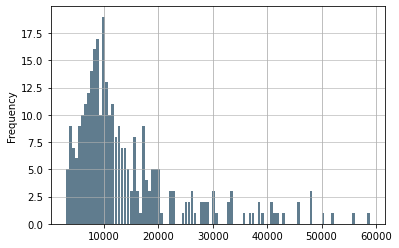

In [12]:
# 看讚數的分佈 y 軸是該讚數的貼文數 來看我們要怎麼取哪個讚數區間資料
commutes = hsu_post['like_count']
commutes.plot.hist(grid=True, bins=100, rwidth=0.9,
color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [13]:
temp = hsu_post[(hsu_post['like_count'] <= 10000) & (hsu_post['like_count'] > 5000)] #讚數大於500 小於1000才取 : 201  篇文章
temp

,new_date,message,jieba_results,like_count
24,2019-03-19,南投市福山里月仔嶺農路歷經水泥與瀝青路面的鋪設，帶給當地民眾相當多的便利性，然而相關維護已是10年前，多年的使用造成該農路產生下陷及龜裂的問題。\n去年福山里許惠菁里長因此事向淑華陳情，淑華也積極向水保局爭取。\n水保局於107年底同意核撥200萬的工程經費，並於3/14完成路面鋪設，解決下陷及龜裂的問題，提供當地鄉親更安全的道路。,南投市 福 山里 月 仔嶺 農路 歷經 水泥 與 瀝青 路面 的 鋪 設 帶給 當地 民眾 相當 多 的 便利性 然而 相關 維護 已 是 年前 多年 的 使用 造成 該 農路 產生 下陷 及 龜裂 的 問題 去年 福 山里 許惠菁 里長 因此 事向淑華陳情 淑華 也 積極 向 水保局 爭取 水保局 於 年底 同意 核撥 萬 的 工程 經費 並 於 完成 路面 鋪設 解決 下陷 及 龜裂 的 問題 提供 當地 鄉親 更 安全 的 道路,5020
25,2019-12-21,竹山鎮林秋圳分線捕給1等2線水利溝，先前爭取第一期工程186萬，今再完成第二期320萬工程。,竹山鎮 林秋圳 分線 捕給 等 線 水利 溝 先前 爭取 第一期 工程 萬 今 再 完成 第二期 萬 工程,5068
26,2019-03-09,琳惟不亂完整版~~\nhttps://yns.page.link/4rekD,琳惟不亂 完整版 ~ ~,5200
27,2019-05-19,台灣體育總會主辦的全國舞藝展演活動昨天於台中市圓滿戶外劇場舉辦\n匯集全國各項舞蹈表演，橆界夥伴們各式多元舞蹈呈現，大家以舞會友，場面熱鬧萬分。,台灣 體育 總會 主辦 的 全國 舞藝 展演 活動 昨天 於 台中市 圓滿戶 外劇場 舉辦 匯集 全國 各項 舞蹈 表演 橆 界 夥伴 們 各式 多元 舞蹈 呈現 大家 以舞會友 場面 熱鬧 萬分,5210
28,2019-04-07,集集鎮田寮里大石公野溪因溪床土石淤積嚴重，若遇大雨恐致生危險，故去年6月時淑華向水保局申請整治經費。近日服務團隊與水保局、設計公司、吳大村前主席、鄧碧惠代表前往會勘，水保局已核准該工程經費500萬元，現正針對該工程進行測量設計，待設計完成後即可發包，確保當地里民之安全。,集集鎮 田寮 里 大石 公野溪 因溪床 土石 淤積 嚴重 若遇 大雨 恐致生 危險 故 去年 月 時淑華向 水保局 申請 整治 經費 近日 服務 團隊 與 水保局 設計 公司 吳大村 前 主席 鄧碧惠 代表 前往 會 勘 水保局 已 核准 該 工程 經費 萬元 現正 針對 該 工程 進行 測量 設計 待 設計 完成 後 即可 發包 確保 當地 里民 之 安全,5215
...,...,...,...,...
134,2019-07-27,休會期間關心地方事務~~\n\n與縣長林明溱、縣議員曾振炎、市民代表陳志斌等人，進行會勘南投市福興里里內擋土牆及南投內轆排水幹線護岸加高改善工程，縣長簽準百萬元工程經費進行改善，以保障民眾的身家財產安全。,休會 期間 關心 地方 事務 ~ ~ 與 縣長 林明溱 縣 議員 曾振炎 市民 代表 陳 志斌 等 人 進行會 勘 南投市 福興里 里 內 擋 土牆 及 南投 內轆 排水 幹線 護岸 加高 改善 工程 縣長 簽準 百萬元 工程 經費 進行 改善 以 保障 民眾 的 身家 財產 安全,9825
135,2019-08-28,與林縣長關心信義鄉「隆華橋」施工進度\n隆華橋是連結台21線與投93線的重要橋梁，支應居民交通、觀光、農產運輸。\n2018年6月遭62水患沖毀，歷經多次風災侵襲受損，淑華與縣長向中央爭取1億2000萬工程費，改建後將有效改善舊橋通洪能力不足等情形，提升兩岸聚落之河防安全，亦可作為下游桐林橋及投93線之替代道路。,與 林縣 長 關心 信義鄉 隆華橋 施工 進度 隆華橋 是 連結台 線 與 投 線 的 重要 橋梁 支應 居民 交通 觀光 農產 運輸 年 月 遭 水患 沖 毀 歷經 多次 風災 侵襲 受損 淑華 與 縣長 向 中央 爭取 億 萬 工程 費 改建 後將 有效 改善 舊橋 通洪 能力 不足 等 情形 提升 兩岸 聚落 之 河防 安全 亦可 作為 下游 桐林 橋及 投 線 之 替代 道路,9828
136,2019-05-17,Uber平台在台灣目前有超過1萬名代僱駕駛。然而台北高等法院 9 日認定公路總局無管轄權，判 Uber 免罰新台幣 1 億元。依公路法第三條規定，交通部、直轄巿政府均為公路主管機關，本件裁罰案件應由「直轄巿公路主管機關」做成，並非公路總局，全案仍可上訴，若終審判決公路總局依然敗訴，這將會是交通部的重大行政瑕疵。\n\n目前4件開罰的案件，1件在台中、3件在台北，若未來公路總局敗訴，交通部應與直轄市政府妥善溝通，避免直轄縣市政府與中央部會互踢皮球，造成無人開罰的狀況產生。而目前計程車司機可以透過車行加入勞保或以自營作業而參加職業工會投保，然目前Uber司機並非工會所認定的自營作業者，而其與Uber並無雇傭關係，所以部分全職駕駛會遇到無法投保勞保的狀況，面對上述問題，交通部應跟勞動部詳加討論，確保勞工權益。Uber爭議延宕至今已兩年，交通部應積極與Uber溝通，並妥善立法以解決目前我國遇到共享經濟所面臨之問題。\n\n而遙控無人機專章修正草案於107年4月3日經立法院三讀通過，上月就曾發生無人機進入機場的事件，導致 5 個航班受影響，可見無人機規管的必要性。然相關法規原訂於108年7月執行，目前卻因為多數地方政府還未提出縣市所在地無人機禁航區圖資，民航局決定將無人機納管上路時程延後至109年，相關法規執行期程延宕，目前過渡期僅能依靠民用航空法第34條針對航空站、飛行場週邊開罰，其餘地區無法可罰，應加速推動專章的執行。\n\n未來無人機專章通過後，航空站、飛行場週邊之取締為航空警察局之權責，地方禁航區為地方政府之權責由地方警局取締或民眾檢舉，目前交通部應跟地方政府做好溝通，掌握各縣市無人機自治條例設置進度，以及是否有足夠的量能做稽查的工作，避免法律設置後執行效果不彰，造成法律形同虛設的窘境。,平台 在 台灣 目前 有 超過 萬名代 僱駕駛 然而 台北 高等法院 日 認定 公路 總局 無 管轄權 判 免罰 新 台幣 億元 依 公路 法 第三 條規定 交通部 直轄 巿 政府 均 為 公路 主管 機關 本件 裁罰 案件 應由 直轄 巿 公路 主管 機關 做成 並非 公路 總局 全案 仍 可 上訴 若終 審判決 公路 總局 依然 敗訴 這將會 是 交通部 的 重大 行政 瑕疵 目前 件 開罰 的 案件 件 在 台 中 件 在 台北 若未來 公路 總局 敗訴 交通部 應 與 直轄 市政府 妥善 溝通 避免 直轄縣 市政府 與 中央部 會互 踢皮球 造成 無人 開罰 的 狀況 產生 而 目前 計程車 司機 可以 透過 車行 加入 勞保 或 以 自營 作業 而 參加 職業工會 投保 然 目前 司機 並非 工會 所 認定 的 自營 作業者 而 其 與 並無 雇傭 關係 所以 部分 全職 駕駛會 遇到 無法 投保 勞保 的 狀況 面對 上述 問題 交通部 應 跟 勞動部 詳加 討論 確保勞 工權益 爭議 延宕 至今 已 兩年 交通部 應積極 與 溝通 並 妥善 立法 以 解決 目前 我國 遇到 共享 經濟 所 面臨 之 問題 而遙 控無人機 專章 修正草案 於 年 月 日經 立法院 三讀 通過 上 月 就 曾 發生 無人機 進入 機場 的 事件 導致 個 航班 受影響 可見 無人機 規管 的 必要性 然 相關 法規 原訂 於 年 月 執行 目前 卻 因為 多數 地方 政府 還未 提出 縣市 所在地 無人 機禁 航區 圖資 民航局 決定 將無人 機納管 上路 時程 延後至 年 相關 法規執 行期 程 延宕 目前 過渡 期僅 能 依靠 民用航空 法 第 條 針對 航空站 飛行場 週邊 開罰 其餘 地區 無法 可罰 應 加速 推動 專章 的 執行 未來 無人機 專章 通過 後 航空站 飛行場 週邊 之取 締為 航空 警察局 之權責 地方 禁航區 為 地方 政府 之權責 由 地方 警局 取締 或民眾 檢舉 目前 交通部 應 跟 地方 政府 做好 溝通 掌握 各縣 市無人機 自治 條例 設置 進度 以及 是否 有足夠 的 量 能 做 稽查 的 工作 避免 法律 設置 後 執行 效果 不彰 造成 法律 形同 虛設 的 窘境,9854
137,2019-08-21,協助縣政府爭取預算約1億3000萬工程\n\n鹿谷鄉著名景點如溪頭、妖怪村、杉林溪及鳳凰谷鳥園等常吸引遊客駐足遊憩，其進出主要依賴151線連繫台3線及國道3號具高便利性及直捷性。\n因假日期間車流甚大，欲藉以分流方式引導北上車流至139線經台16線往國道3號連接，因139線終點處與151線交會處之路段房屋密集拆遷困難，目前仍維持約4M路寬，僅可供小型車通行。\n其與151線交會口處之151線為一陡坡及大轉彎，目前雖設有交通號誌，仍是一處視距不良之危險路口，目前139線僅可於初鄉國小前路口循既有8M寬道路北側銜接151線，然其為一繞路動線不利行車。\n且該交會路口位於回頭彎及陡坡，路口動線不佳，視距不良之危險路口，因此地方人士莫不希望找出一條便捷通道連絡兩道路。\n縣府於107年度向中央申請本案之計畫補助，並已奉交通部核定「生活圈道路交通系統建設計畫(公路系統)8年(104-111)計畫」補助辦理，如能便捷串連151線

TF-IDF
我們把剛才斷好詞的貼文，轉成list形式，全部放到corpus變數裡面，方便做tf-idf處理。

CountVectorizer算字頻（搭配fit_transform）
TfidfTransformer計算TFIDF

In [14]:
corpus = temp['jieba_results'].values.tolist() #如果不做這個、結果會不同 太generall

In [15]:
# TF-IDF
# coding:utf-8  

#算字頻
from sklearn.feature_extraction.text import CountVectorizer  
vectorizer = CountVectorizer()  # 計算單字出現在文件中的次數
X = vectorizer.fit_transform(corpus) #  input must be a list, return a matrix (#of corpus) x (# of word) # 201 x 4835
word = vectorizer.get_feature_names() # column name which is the word
message_column = word

#計算TFIDF
from sklearn.feature_extraction.text import TfidfTransformer  # 計算tfidf
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X) # X : corpus x word matrix, output:201 x 4835

In [16]:
tfidf_view = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names())
tfidf_view

,一一,一下,一件,一休,一併,一例,一個,一再,一口,一同,...,黑數,默默,點也,點的載,點點,黨內,黨籍,鼓勵,龍井,龜裂
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294784
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [17]:
# #使用LDA演算法
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=6, random_state=None)
LDA.fit(X) # 用countrvectorizer() result 去fit 

topic_message = list()
#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    mes_topic = [vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(mes_topic)
    for i in mes_topic:
        topic_message.append(i)

TOP 10 WORDS PER TOPIC #0
['賴清德', '產業', '提出', '關稅', '酒癮', '造成', '相關', '我國', '南投縣', '酒駕']
TOP 10 WORDS PER TOPIC #1
['美食', '水保局', '經費', '工程', '南投縣', '營業', '南投市', '地址', '時間', '南投']
TOP 10 WORDS PER TOPIC #2
['使用', '工程', '相關', '目前', '造成', '補助', '政府', '南投', '交通部', '狀況']
TOP 10 WORDS PER TOPIC #3
['調查', '造成', '狀況', '公路', '相關', '計程車', '新村', '交通部', '中興', '目前']
TOP 10 WORDS PER TOPIC #4
['目前', '南投', '交通部', '國際', '爭取', '南投縣', '遊客', '竹山', '竹山鎮', '觀光']
TOP 10 WORDS PER TOPIC #5
['計畫', '旅客', '南投縣', '發展', '目前', '補助', '產業', '政府', '觀光', '南投']


In [18]:
LDA.fit(tfidf) # 用tfidf result 去fit 

#觀看結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['南投市', '南投縣', '時間', '工程', '山路', '完整版', '琳惟不亂', '竹山鎮', '竹山', '南投']
TOP 10 WORDS PER TOPIC #1
['水系', '地方', '支持', '改善', '淑華', '自來', '竹山', '南投市', '爭取', '國民黨']
TOP 10 WORDS PER TOPIC #2
['號新北市', '三重', '米糕', '聯合', '觀光', '文化', '總部', '競選', '名間', '南投']
TOP 10 WORDS PER TOPIC #3
['中興', '目前', '水保局', '名間', '元宵', '大家', '節快', '工程', '堤防', '座談會']
TOP 10 WORDS PER TOPIC #4
['淑華', '水餃', '採茶', '有空', '南投縣', '電話', '爭取', '鄉親', '工程', '南投']
TOP 10 WORDS PER TOPIC #5
['電話', '計程車', '時間', '地址', '南投縣', '南投市', '專區', '南投', '美食', '營業']


In [19]:
#政見做斷詞

politics_hsu = politics[politics.姓名 == "許 淑 華"].政見.to_string()
politics_hsu = re.sub(re_punctuation, "", politics_hsu)
politics_hsu = re.sub(r'[0-9]','',politics_hsu)
politics_hsu = re.sub(r'[a-zA-Z]','',politics_hsu)
politics_hsu = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗]','',politics_hsu)  # 注意裡面不能有空白！
jieba.load_userdict("dict.txt")
words = jieba.lcut(politics_hsu, cut_all = False)


In [20]:
#觀察政見的斷詞結果
inspect_words = jieba.cut(politics_hsu, cut_all = False)
text = ''
for word in inspect_words:
    text = text + ' ' + str(word) 
text = re.sub(r'[-<>#。！⋯.➡?=&▶_%♀!❗]','',text)
text = re.sub(re_punctuation, "", text)



In [21]:
# 政見做tfidf
p_vectorizer = CountVectorizer()  
p_X = p_vectorizer.fit_transform(words)  
word = p_vectorizer.get_feature_names() 
p_transformer = TfidfTransformer()  
p_tfidf = p_transformer.fit_transform(p_X) #143 word in 

p_LDA = LatentDirichletAllocation(n_components=8, random_state=None)

#政見做LDA
p_LDA.fit(p_tfidf)
topic_politics = list()
#觀看結果
for i,topic in enumerate(p_LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    topic_p = [p_vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]]
    print(topic_p)
    for i in topic_p:
        topic_politics.append(i)


TOP 10 WORDS PER TOPIC #0
['有助', '輔助', '社會平權法令', '全民福祉', '改善', '建構', '俾利', '加強', '優質', '國家']
TOP 10 WORDS PER TOPIC #1
['交通', '落實', '創意', '活化', '進步文明', '均衡', '工商產業', '增列', '醫療水平', '偏遠路況']
TOP 10 WORDS PER TOPIC #2
['振興', '弱勢社團', '地方發展', '利民', '利生', '全面', '生活', '環保家園', '環境', '精緻農業']
TOP 10 WORDS PER TOPIC #3
['輔助', '振興', '中央經費', '增益', '佐助', '修改', '農民收益', '選民服務', '重視', '綠色法令']
TOP 10 WORDS PER TOPIC #4
['助老幼濟貧弱', '輔助', '不合時宜', '爭取', '福利', '社會資源', '推動', '各項', '觀光', '豐裕']
TOP 10 WORDS PER TOPIC #5
['輔助', '振興', '爭取', '有助', '扶植', '助老幼濟貧弱', '美化', '城鄉落差', '教育', '發展']
TOP 10 WORDS PER TOPIC #6
['爭取', '助老幼濟貧弱', '振興', '不合時宜', '扶植', '輔助', '施政', '平等', '制定', '教育環境']
TOP 10 WORDS PER TOPIC #7
['有助', '振興', '爭取', '多元', '公民', '利國', '全國', '偏鄉醫政', '法令', '文化']


In [22]:
# #政見所有topic 總表
for i in topic_politics:
#for i in topic_:# 文章內容的topic所有字的總表
    print(i,end = ', ')

有助, 輔助, 社會平權法令, 全民福祉, 改善, 建構, 俾利, 加強, 優質, 國家, 交通, 落實, 創意, 活化, 進步文明, 均衡, 工商產業, 增列, 醫療水平, 偏遠路況, 振興, 弱勢社團, 地方發展, 利民, 利生, 全面, 生活, 環保家園, 環境, 精緻農業, 輔助, 振興, 中央經費, 增益, 佐助, 修改, 農民收益, 選民服務, 重視, 綠色法令, 助老幼濟貧弱, 輔助, 不合時宜, 爭取, 福利, 社會資源, 推動, 各項, 觀光, 豐裕, 輔助, 振興, 爭取, 有助, 扶植, 助老幼濟貧弱, 美化, 城鄉落差, 教育, 發展, 爭取, 助老幼濟貧弱, 振興, 不合時宜, 扶植, 輔助, 施政, 平等, 制定, 教育環境, 有助, 振興, 爭取, 多元, 公民, 利國, 全國, 偏鄉醫政, 法令, 文化, 

In [23]:
#在LDA結果中每個Topic政見的詞 、 臉書貼文的詞的交集 
#set(topic_politics).intersection(topic_message) 
Counter(topic_politics+topic_message) #綜合臉書發文、政見 Topic 的詞 看出現次數
#產業升級、園區、高科技園區、加工區 、楠梓、交通、三鐵同構

Counter({'有助': 3,
         '輔助': 5,
         '社會平權法令': 1,
         '全民福祉': 1,
         '改善': 1,
         '建構': 1,
         '俾利': 1,
         '加強': 1,
         '優質': 1,
         '國家': 1,
         '交通': 1,
         '落實': 1,
         '創意': 1,
         '活化': 1,
         '進步文明': 1,
         '均衡': 1,
         '工商產業': 1,
         '增列': 1,
         '醫療水平': 1,
         '偏遠路況': 1,
         '振興': 5,
         '弱勢社團': 1,
         '地方發展': 1,
         '利民': 1,
         '利生': 1,
         '全面': 1,
         '生活': 1,
         '環保家園': 1,
         '環境': 1,
         '精緻農業': 1,
         '中央經費': 1,
         '增益': 1,
         '佐助': 1,
         '修改': 1,
         '農民收益': 1,
         '選民服務': 1,
         '重視': 1,
         '綠色法令': 1,
         '助老幼濟貧弱': 3,
         '不合時宜': 2,
         '爭取': 5,
         '福利': 1,
         '社會資源': 1,
         '推動': 1,
         '各項': 1,
         '觀光': 3,
         '豐裕': 1,
         '扶植': 2,
         '美化': 1,
         '城鄉落差': 1,
         '教育': 1,
         '發展': 2,
         '施政': 1,
      

我們可以用 臉書貼文和政見 Topic word 的交集 會推測
劉世芳的幾個重點
1. 經濟相關的科技 園區和加工區
    - 高科技、發展、產業、加工區、園區、產業、就業、計畫、建設、
2. 楠梓地區
    -楠梓
3. 交通
    -三鐵同構、中油、交通、
4. 環境
    -環境、綠能、

職災 相關tf idf 高 (以下討論臉書貼文)

In [24]:
top_10_message = tfidf_view.sort_values(by = ['交通'], ascending = False).index[:10] # 把高科技tfidf 高的文章做排序取top 10的文章 拿出文章的index
tfidf_view.sort_values(by = ['交通'], ascending = False).head(10)

,一一,一下,一件,一休,一併,一例,一個,一再,一口,一同,...,黑數,默默,點也,點的載,點點,黨內,黨籍,鼓勵,龍井,龜裂
17,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.055896,0.000000,0.055896,0.042059,0.045775,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,0.0,0.0,0.0,0.000000,0.042282,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.000000,0.054204,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.02802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[17,]).sort_values(by = 17, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,17
水利,0.330934
縣府,0.261204
國產署,0.179880
撥用,0.179880
召集,0.179880
...,...
局還,0.000000
局長,0.000000
屁股,0.000000
居服,0.000000


In [26]:
top_10_message = tfidf_view.sort_values(by = ['韓國瑜'], ascending = False).index[:10] # 把高科技tfidf 高的文章做排序取top 10的文章 拿出文章的index
tfidf_view.sort_values(by = ['韓國瑜'], ascending = False).head(10)

,一一,一下,一件,一休,一併,一例,一個,一再,一口,一同,...,黑數,默默,點也,點的載,點點,黨內,黨籍,鼓勵,龍井,龜裂
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294784
73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [27]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[12,]).sort_values(by = 12, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,12
南投,0.364306
拚經濟,0.231324
新聞網,0.231324
吉利,0.231324
劉登周,0.231324
...,...
尼莎,0.000000
局所,0.000000
局還,0.000000
局長,0.000000


In [28]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[42,]).sort_values(by = 42, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,42
捐款,0.372325
分機,0.269837
好友,0.232877
筆的,0.134919
愛心,0.134919
...,...
局還,0.000000
局長,0.000000
屁股,0.000000
居服,0.000000


In [29]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[0,]).sort_values(by = 0, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,0
龜裂,0.294784
下陷,0.294784
山里,0.294784
路面,0.294784
農路,0.254407
...,...
尼莎,0.000000
局所,0.000000
局還,0.000000
局長,0.000000


In [30]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[73,]).sort_values(by = 73, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,73
力拼,0.302925
新住民,0.302925
後援會,0.302925
卓越,0.302925
青工,0.302925
...,...
就是,0.000000
就會,0.000000
就業機會,0.000000
就算,0.000000


In [31]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[84,]).sort_values(by = 84, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,84
多汁,0.2133
頭絲,0.2133
炸芋,0.2133
炒桂竹筍,0.2133
百菇湯,0.2133
...,...
就算,0.0000
尼莎,0.0000
局所,0.0000
局還,0.0000


In [32]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[83,]).sort_values(by = 83, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,83
座談會,0.466940
轉涼,0.262249
感覺,0.262249
讓淑華,0.262249
溫馨,0.246041
...,...
就是,0.000000
就會,0.000000
就業機會,0.000000
就算,0.000000


In [33]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[82,]).sort_values(by = 82, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,82
參觀,0.470007
相見歡,0.470007
長輩,0.432348
老人,0.384903
立法院,0.367970
...,...
就是,0.000000
就會,0.000000
就業機會,0.000000
就算,0.000000


In [34]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[81,]).sort_values(by = 81, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,81
一老,0.408248
如有,0.408248
家有,0.408248
快樂,0.408248
一寶,0.408248
...,...
就會,0.000000
就業機會,0.000000
就算,0.000000
尼莎,0.000000


In [35]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[80,]).sort_values(by = 80, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,80
開啟,0.148785
社區發展協會,0.148785
投射,0.148785
風雅,0.148785
花序,0.148785
...,...
就算,0.000000
尼莎,0.000000
局所,0.000000
局還,0.000000


In [36]:
#把上面的文章個別拿出文章來看他們文章tfidf值 發現可能在"高科技"的tfidf 和所有文章比較算很高，但是個別這些文章，這些文章還有更可以代表他的term
pd.DataFrame(tfidf_view.iloc[79,]).sort_values(by = 79, ascending=False)
#pd.DataFrame(tfidf_view.iloc[65,]).sort_values(by = 65, ascending=False)
# bad attemption 


,79
肉羹,0.362446
廟口魚,0.362446
美食,0.190701
手藝,0.181223
一手,0.181223
...,...
尼莎,0.000000
局所,0.000000
局還,0.000000
局長,0.000000


In [37]:
#這些都是讚數很高的文章 每篇文章最高的tfidf 詞
message_newtfidf = tfidf_view
message_newtfidf['term'] = message_newtfidf[message_column].idxmax(axis = 1)
message_newtfidf['term'].tail(20) # 在這邊的話看讚數最多的文章他們tfidf 最高的詞是什麼

95      頻率
96      筍子
97      土石
98     運動會
99      上帝
100     一邊
101     並將
102     梅子
103     食堂
104     梅子
105     茶葉
106     工程
107    南投市
108     從政
109     三重
110     縣長
111    隆華橋
112     公路
113     路口
114     村民
Name: term, dtype: object

In [38]:
#假如以剛剛科學園區相關主題為例 想看tfidf 最高的詞是科學園區的文章
message_newtfidf[message_newtfidf['term']=="頻率"]

,一一,一下,一件,一休,一併,一例,一個,一再,一口,一同,...,默默,點也,點的載,點點,黨內,黨籍,鼓勵,龍井,龜裂,term
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,頻率


In [39]:
# 會發現文章出現tfidf是產業的很少，很正常 因為出現太多反而tfidf不會高！
temp.iloc[95,]

new_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        2019-09-23
message                                                                                                                                                                      

來看楠梓 ： 在臉書發文的topic中topic2,4,7 出現很多次楠梓 

In [40]:
message_newtfidf[message_newtfidf['term']=="觀光"]

,一一,一下,一件,一休,一併,一例,一個,一再,一口,一同,...,默默,點也,點的載,點點,黨內,黨籍,鼓勵,龍井,龜裂,term
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,觀光
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,觀光


In [41]:
temp.iloc[56,]

new_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [42]:
temp.iloc[90,]

new_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [43]:
# LDA : 看每篇文章被分配在哪些主題  (tfidf)
#review topic 結果
for i,topic in enumerate(LDA.components_):
    print(f"TOP 10 WORDS PER TOPIC #{i}")
    print([vectorizer.get_feature_names()[index] for index in topic.argsort()[-10:]])

TOP 10 WORDS PER TOPIC #0
['南投市', '南投縣', '時間', '工程', '山路', '完整版', '琳惟不亂', '竹山鎮', '竹山', '南投']
TOP 10 WORDS PER TOPIC #1
['水系', '地方', '支持', '改善', '淑華', '自來', '竹山', '南投市', '爭取', '國民黨']
TOP 10 WORDS PER TOPIC #2
['號新北市', '三重', '米糕', '聯合', '觀光', '文化', '總部', '競選', '名間', '南投']
TOP 10 WORDS PER TOPIC #3
['中興', '目前', '水保局', '名間', '元宵', '大家', '節快', '工程', '堤防', '座談會']
TOP 10 WORDS PER TOPIC #4
['淑華', '水餃', '採茶', '有空', '南投縣', '電話', '爭取', '鄉親', '工程', '南投']
TOP 10 WORDS PER TOPIC #5
['電話', '計程車', '時間', '地址', '南投縣', '南投市', '專區', '南投', '美食', '營業']


In [44]:
#可以猜猜看第一篇文是哪個topic 
temp.iloc[:,[0,2]]

,new_date,jieba_results
24,2019-03-19,南投市 福 山里 月 仔嶺 農路 歷經 水泥 與 瀝青 路面 的 鋪 設 帶給 當地 民眾 相當 多 的 便利性 然而 相關 維護 已 是 年前 多年 的 使用 造成 該 農路 產生 下陷 及 龜裂 的 問題 去年 福 山里 許惠菁 里長 因此 事向淑華陳情 淑華 也 積極 向 水保局 爭取 水保局 於 年底 同意 核撥 萬 的 工程 經費 並 於 完成 路面 鋪設 解決 下陷 及 龜裂 的 問題 提供 當地 鄉親 更 安全 的 道路
25,2019-12-21,竹山鎮 林秋圳 分線 捕給 等 線 水利 溝 先前 爭取 第一期 工程 萬 今 再 完成 第二期 萬 工程
26,2019-03-09,琳惟不亂 完整版 ~ ~
27,2019-05-19,台灣 體育 總會 主辦 的 全國 舞藝 展演 活動 昨天 於 台中市 圓滿戶 外劇場 舉辦 匯集 全國 各項 舞蹈 表演 橆 界 夥伴 們 各式 多元 舞蹈 呈現 大家 以舞會友 場面 熱鬧 萬分
28,2019-04-07,集集鎮 田寮 里 大石 公野溪 因溪床 土石 淤積 嚴重 若遇 大雨 恐致生 危險 故 去年 月 時淑華向 水保局 申請 整治 經費 近日 服務 團隊 與 水保局 設計 公司 吳大村 前 主席 鄧碧惠 代表 前往 會 勘 水保局 已 核准 該 工程 經費 萬元 現正 針對 該 工程 進行 測量 設計 待 設計 完成 後 即可 發包 確保 當地 里民 之 安全
...,...,...
134,2019-07-27,休會 期間 關心 地方 事務 ~ ~ 與 縣長 林明溱 縣 議員 曾振炎 市民 代表 陳 志斌 等 人 進行會 勘 南投市 福興里 里 內 擋 土牆 及 南投 內轆 排水 幹線 護岸 加高 改善 工程 縣長 簽準 百萬元 工程 經費 進行 改善 以 保障 民眾 的 身家 財產 安全
135,2019-08-28,與 林縣 長 關心 信義鄉 隆華橋 施工 進度 隆華橋 是 連結台 線 與 投 線 的 重要 橋梁 支應 居民 交通 觀光 農產 運輸 年 月 遭 水患 沖 毀 歷經 多次 風災 侵襲 受損 淑華 與 縣長 向 中央 爭取 億 萬 工程 費 改建 後將 有效 改善 舊橋 通洪 能力 不足 等 情形 提升 兩岸 聚落 之 河防 安全 亦可 作為 下游 桐林 橋及 投 線 之 替代 道路
136,2019-05-17,平台 在 台灣 目前 有 超過 萬名代 僱駕駛 然而 台北 高等法院 日 認定 公路 總局 無 管轄權 判 免罰 新 台幣 億元 依 公路 法 第三 條規定 交通部 直轄 巿 政府 均 為 公路 主管 機關 本件 裁罰 案件 應由 直轄 巿 公路 主管 機關 做成 並非 公路 總局 全案 仍 可 上訴 若終 審判決 公路 總局 依然 敗訴 這將會 是 交通部 的 重大 行政 瑕疵 目前 件 開罰 的 案件 件 在 台 中 件 在 台北 若未來 公路 總局 敗訴 交通部 應 與 直轄 市政府 妥善 溝通 避免 直轄縣 市政府 與 中央部 會互 踢皮球 造成 無人 開罰 的 狀況 產生 而 目前 計程車 司機 可以 透過 車行 加入 勞保 或 以 自營 作業 而 參加 職業工會 投保 然 目前 司機 並非 工會 所 認定 的 自營 作業者 而 其 與 並無 雇傭 關係 所以 部分 全職 駕駛會 遇到 無法 投保 勞保 的 狀況 面對 上述 問題 交通部 應 跟 勞動部 詳加 討論 確保勞 工權益 爭議 延宕 至今 已 兩年 交通部 應積極 與 溝通 並 妥善 立法 以 解決 目前 我國 遇到 共享 經濟 所 面臨 之 問題 而遙 控無人機 專章 修正草案 於 年 月 日經 立法院 三讀 通過 上 月 就 曾 發生 無人機 進入 機場 的 事件 導致 個 航班 受影響 可見 無人機 規管 的 必要性 然 相關 法規 原訂 於 年 月 執行 目前 卻 因為 多數 地方 政府 還未 提出 縣市 所在地 無人 機禁 航區 圖資 民航局 決定 將無人 機納管 上路 時程 延後至 年 相關 法規執 行期 程 延宕 目前 過渡 期僅 能 依靠 民用航空 法 第 條 針對 航空站 飛行場 週邊 開罰 其餘 地區 無法 可罰 應 加速 推動 專章 的 執行 未來 無人機 專章 通過 後 航空站 飛行場 週邊 之取 締為 航空 警察局 之權責 地方 禁航區 為 地方 政府 之權責 由 地方 警局 取締 或民眾 檢舉 目前 交通部 應 跟 地方 政府 做好 溝通 掌握 各縣 市無人機 自治 條例 設置 進度 以及 是否 有足夠 的 量 能 做 稽查 的 工作 避免 法律 設置 後 執行 效果 不彰 造成 法律 形同 虛設 的 窘境
137,2019-08-21,協助 縣 政府 爭取 預算約 億 萬 工程 鹿谷鄉 著名 景點 如溪頭 妖怪 村 杉林溪 及鳳凰谷 鳥園 等 常 吸引 遊客 駐足 遊憩 其 進出 主要 依賴 線 連 繫 台 線及 國道 號具 高 便利性 及 直捷 性 因假 日期 間 車流 甚大 欲 藉以 分流 方式 引導 北上 車流 至 線經台 線往 國道 號連接 因 線 終點 處 與 線交會 處 之 路段 房屋 密集 拆遷 困難 目前 仍維持 約 路 寬 僅可供 小型 車 通行 其 與 線交會口 處 之 線為 一 陡坡 及大轉 彎 目前 雖設 有 交通 號誌 仍 是 一處 視距 不良 之 危險 路口 目前 線僅 可 於 初鄉 國小 前 路口 循 既有 寬 道路 北側 銜接 線 然其為 一繞 路動線 不利 行車 且 該 交會 路口 位 於 回頭 彎及 陡坡 路口 動線 不佳 視距 不良 之 危險 路口 因此 地方 人士 莫不 希望 找出 一條 便捷 通道 連絡 兩 道路 縣府 於 年度 向 中央 申請 本案 之 計畫 補助 並已 奉 交通部 核定 生活圈 道路交通 系統 建設 計畫 公路 系統 年 計畫 補助 辦理 如能 便捷 串連 線及 線 有利於 鹿谷 集集 及 水里 等 觀光 產業 發展


In [45]:
#LDA classification 
temp["topic"]=""#add new column 

doc_topic = LDA.transform(tfidf)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()

    temp.iloc[n,4] = topic_most_pr
temp

<ipython-input-45-3dbfd841bfcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["topic"]=""#add new column
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,new_date,message,jieba_results,like_count,topic
24,2019-03-19,南投市福山里月仔嶺農路歷經水泥與瀝青路面的鋪設，帶給當地民眾相當多的便利性，然而相關維護已是10年前，多年的使用造成該農路產生下陷及龜裂的問題。\n去年福山里許惠菁里長因此事向淑華陳情，淑華也積極向水保局爭取。\n水保局於107年底同意核撥200萬的工程經費，並於3/14完成路面鋪設，解決下陷及龜裂的問題，提供當地鄉親更安全的道路。,南投市 福 山里 月 仔嶺 農路 歷經 水泥 與 瀝青 路面 的 鋪 設 帶給 當地 民眾 相當 多 的 便利性 然而 相關 維護 已 是 年前 多年 的 使用 造成 該 農路 產生 下陷 及 龜裂 的 問題 去年 福 山里 許惠菁 里長 因此 事向淑華陳情 淑華 也 積極 向 水保局 爭取 水保局 於 年底 同意 核撥 萬 的 工程 經費 並 於 完成 路面 鋪設 解決 下陷 及 龜裂 的 問題 提供 當地 鄉親 更 安全 的 道路,5020,4
25,2019-12-21,竹山鎮林秋圳分線捕給1等2線水利溝，先前爭取第一期工程186萬，今再完成第二期320萬工程。,竹山鎮 林秋圳 分線 捕給 等 線 水利 溝 先前 爭取 第一期 工程 萬 今 再 完成 第二期 萬 工程,5068,4
26,2019-03-09,琳惟不亂完整版~~\nhttps://yns.page.link/4rekD,琳惟不亂 完整版 ~ ~,5200,0
27,2019-05-19,台灣體育總會主辦的全國舞藝展演活動昨天於台中市圓滿戶外劇場舉辦\n匯集全國各項舞蹈表演，橆界夥伴們各式多元舞蹈呈現，大家以舞會友，場面熱鬧萬分。,台灣 體育 總會 主辦 的 全國 舞藝 展演 活動 昨天 於 台中市 圓滿戶 外劇場 舉辦 匯集 全國 各項 舞蹈 表演 橆 界 夥伴 們 各式 多元 舞蹈 呈現 大家 以舞會友 場面 熱鬧 萬分,5210,5
28,2019-04-07,集集鎮田寮里大石公野溪因溪床土石淤積嚴重，若遇大雨恐致生危險，故去年6月時淑華向水保局申請整治經費。近日服務團隊與水保局、設計公司、吳大村前主席、鄧碧惠代表前往會勘，水保局已核准該工程經費500萬元，現正針對該工程進行測量設計，待設計完成後即可發包，確保當地里民之安全。,集集鎮 田寮 里 大石 公野溪 因溪床 土石 淤積 嚴重 若遇 大雨 恐致生 危險 故 去年 月 時淑華向 水保局 申請 整治 經費 近日 服務 團隊 與 水保局 設計 公司 吳大村 前 主席 鄧碧惠 代表 前往 會 勘 水保局 已 核准 該 工程 經費 萬元 現正 針對 該 工程 進行 測量 設計 待 設計 完成 後 即可 發包 確保 當地 里民 之 安全,5215,3
...,...,...,...,...,...
134,2019-07-27,休會期間關心地方事務~~\n\n與縣長林明溱、縣議員曾振炎、市民代表陳志斌等人，進行會勘南投市福興里里內擋土牆及南投內轆排水幹線護岸加高改善工程，縣長簽準百萬元工程經費進行改善，以保障民眾的身家財產安全。,休會 期間 關心 地方 事務 ~ ~ 與 縣長 林明溱 縣 議員 曾振炎 市民 代表 陳 志斌 等 人 進行會 勘 南投市 福興里 里 內 擋 土牆 及 南投 內轆 排水 幹線 護岸 加高 改善 工程 縣長 簽準 百萬元 工程 經費 進行 改善 以 保障 民眾 的 身家 財產 安全,9825,2
135,2019-08-28,與林縣長關心信義鄉「隆華橋」施工進度\n隆華橋是連結台21線與投93線的重要橋梁，支應居民交通、觀光、農產運輸。\n2018年6月遭62水患沖毀，歷經多次風災侵襲受損，淑華與縣長向中央爭取1億2000萬工程費，改建後將有效改善舊橋通洪能力不足等情形，提升兩岸聚落之河防安全，亦可作為下游桐林橋及投93線之替代道路。,與 林縣 長 關心 信義鄉 隆華橋 施工 進度 隆華橋 是 連結台 線 與 投 線 的 重要 橋梁 支應 居民 交通 觀光 農產 運輸 年 月 遭 水患 沖 毀 歷經 多次 風災 侵襲 受損 淑華 與 縣長 向 中央 爭取 億 萬 工程 費 改建 後將 有效 改善 舊橋 通洪 能力 不足 等 情形 提升 兩岸 聚落 之 河防 安全 亦可 作為 下游 桐林 橋及 投 線 之 替代 道路,9828,1
136,2019-05-17,Uber平台在台灣目前有超過1萬名代僱駕駛。然而台北高等法院 9 日認定公路總局無管轄權，判 Uber 免罰新台幣 1 億元。依公路法第三條規定，交通部、直轄巿政府均為公路主管機關，本件裁罰案件應由「直轄巿公路主管機關」做成，並非公路總局，全案仍可上訴，若終審判決公路總局依然敗訴，這將會是交通部的重大行政瑕疵。\n\n目前4件開罰的案件，1件在台中、3件在台北，若未來公路總局敗訴，交通部應與直轄市政府妥善溝通，避免直轄縣市政府與中央部會互踢皮球，造成無人開罰的狀況產生。而目前計程車司機可以透過車行加入勞保或以自營作業而參加職業工會投保，然目前Uber司機並非工會所認定的自營作業者，而其與Uber並無雇傭關係，所以部分全職駕駛會遇到無法投保勞保的狀況，面對上述問題，交通部應跟勞動部詳加討論，確保勞工權益。Uber爭議延宕至今已兩年，交通部應積極與Uber溝通，並妥善立法以解決目前我國遇到共享經濟所面臨之問題。\n\n而遙控無人機專章修正草案於107年4月3日經立法院三讀通過，上月就曾發生無人機進入機場的事件，導致 5 個航班受影響，可見無人機規管的必要性。然相關法規原訂於108年7月執行，目前卻因為多數地方政府還未提出縣市所在地無人機禁航區圖資，民航局決定將無人機納管上路時程延後至109年，相關法規執行期程延宕，目前過渡期僅能依靠民用航空法第34條針對航空站、飛行場週邊開罰，其餘地區無法可罰，應加速推動專章的執行。\n\n未來無人機專章通過後，航空站、飛行場週邊之取締為航空警察局之權責，地方禁航區為地方政府之權責由地方警局取締或民眾檢舉，目前交通部應跟地方政府做好溝通，掌握各縣市無人機自治條例設置進度，以及是否有足夠的量能做稽查的工作，避免法律設置後執行效果不彰，造成法律形同虛設的窘境。,平台 在 台灣 目前 有 超過 萬名代 僱駕駛 然而 台北 高等法院 日 認定 公路 總局 無 管轄權 判 免罰 新 台幣 億元 依 公路 法 第三 條規定 交通部 直轄 巿 政府 均 為 公路 主管 機關 本件 裁罰 案件 應由 直轄 巿 公路 主管 機關 做成 並非 公路 總局 全案 仍 可 上訴 若終 審判決 公路 總局 依然 敗訴 這將會 是 交通部 的 重大 行政 瑕疵 目前 件 開罰 的 案件 件 在 台 中 件 在 台北 若未來 公路 總局 敗訴 交通部 應 與 直轄 市政府 妥善 溝通 避免 直轄縣 市政府 與 中央部 會互 踢皮球 造成 無人 開罰 的 狀況 產生 而 目前 計程車 司機 可以 透過 車行 加入 勞保 或 以 自營 作業 而 參加 職業工會 投保 然 目前 司機 並非 工會 所 認定 的 自營 作業者 而 其 與 並無 雇傭 關係 所以 部分 全職 駕駛會 遇到 無法 投保 勞保 的 狀況 面對 上述 問題 交通部 應 跟 勞動部 詳加 討論 確保勞 工權益 爭議 延宕 至今 已 兩年 交通部 應積極 與 溝通 並 妥善 立法 以 解決 目前 我國 遇到 共享 經濟 所 面臨 之 問題 而遙 控無人機 專章 修正草案 於 年 月 日經 立法院 三讀 通過 上 月 就 曾 發生 無人機 進入 機場 的 事件 導致 個 航班 受影響 可見 無人機 規管 的 必要性 然 相關 法規 原訂 於 年 月 執行 目前 卻 因為 多數 地方 政府 還未 提出 縣市 所在地 無人 機禁 航區 圖資 民航局 決定 將無人 機納管 上路 時程 延後至 年 相關 法規執 行期 程 延宕 目前 過渡 期僅 能 依靠 民用航空 法 第 條 針對 航空站 飛行場 週邊 開罰 其餘 地區 無法 可罰 應 加速 推動 專章 的 執行 未來 無人機 專章 通過 後 航空站 飛行場 週邊 之取 締為 航空 警察局 之權責 地方 禁航區 為 地方 政府 之權責 由 地方 警局 取締 或民眾 檢舉 目前 交通部 應 跟 地方 政府 做好 溝通 掌握 各縣 市無人機 自治 條例 設置 進度 以及 是否 有足夠 的 量 能 做 稽查 的 工作 避免 法律 設置 後 執行 效果 不彰 造成 法律 形同 虛設 的 窘境,9854,3
137,2019-08-21,協助縣政府爭取預算約1億3000萬工程\n\n鹿谷鄉著名景點如溪頭、妖怪村、杉林溪及鳳凰谷鳥園等常吸引遊客駐足遊憩，其進出主要依賴151線連繫台3線及國道3號具高便利性及直捷性。\n因假日期間車流甚大，欲藉以分流方式引導北上車流至139線經台16線往國道3號連接，因139線終點處與151線交會處之路段房屋密集拆遷困難，目前仍維持約4M路寬，僅可供小型車通行。\n其與151線交會口處之151線為一陡坡及大轉彎，目前雖設有交通號誌，仍是一處視距不良之危險路口，目前139線僅可於初鄉國小前路口循既有8M寬道路北側銜接151線，然其為一繞路動線不利行車。\n且該交會路口位於回頭彎及陡坡，路口動線不佳，視距不良之危險路口，因此地方人士莫不希望找出一條便捷通道連絡兩道路。\n縣府於107年度向中央申請本案之計畫補助，並已奉交通部核定「生活圈道路交通系統建設計畫(公路系統)8年(

可以看到第19 貼文 真的是和topic5:服務 有關
        23貼文 也屬於topic4: 市場 相關

In [46]:
Counter(temp.iloc[-20:, 4])
#這邊可以看到在讚數top20 多的那些文章中 哪些主題比較熱門
#Topic 0,5,7 這些主題相關比較熱門

Counter({5: 3, 2: 5, 3: 3, 0: 3, 1: 5, 4: 1})

臉書發文的Topic 0,5,7比較常出現 
TOP 10 WORDS PER TOPIC #0
['高雄市', '大家', '一抹黑', '一天', '注意', '安全', '世芳', '朋友', '分享', '台灣']

TOP 10 WORDS PER TOPIC #5
['美國', '工程', '我們', '大雨', '改變', '提高', '國家', '自由', '發言', '台灣']

TOP 10 WORDS PER TOPIC #7
['經濟', '軍人節', '問好', '自由黃昏市場', '初選', '台灣', '市長', '楠梓', '我們', '韓市']

回去對政見做印證
政見Topic 
TOP 10 WORDS PER TOPIC #0
['東西', '共同', '安居樂業', '帶動', '文化', '強化', '保存', '交通', '政策', '推動']
TOP 10 WORDS PER TOPIC #1
['實現', '交流', '新綠園', '北上', '地方', '廣設', '升級', '結合', '規劃', '園區']
TOP 10 WORDS PER TOPIC #2
['家庭', '延續', '南遷', '宿舍', '檢討', '左楠', '綠能', '黨產處', '高科技', '開闢']
TOP 10 WORDS PER TOPIC #3
['廠區', '啟動', '移入', '聯外', '通過', '接國', '引入', '政黨', '功能', '盡速']
TOP 10 WORDS PER TOPIC #4
['整合', '區的', '道國', '中心', '打造', '重新', '楠梓', '正義', '形成', '總部']
TOP 10 WORDS PER TOPIC #5
['觀光', '活化', '朝向', '建立', '融入', '三鐵共構', '眷村', '自主', '發展', '中油']
TOP 10 WORDS PER TOPIC #6
['財稅', '追求', '照護', '人口', '就業', '安置', '新門戶', '生態', '社區', '轉型']
TOP 10 WORDS PER TOPIC #7
['持續', '環境', '十字', '打通', '生活', '台灣', '加工區', '防衛', '聚落', '產業']

楠梓在政見中有出現、且在臉書發文也出現不少次，可以互相對應，算是政見、發文互相有符合的詞
但是除了楠梓以外 其他政見比較少在發文中提到
且上次數字型資料分析結果，劉世芳讚數多的貼文言詞都比較有侵略性，內容多數在品評時事的過失，有點蹭時事熱度的感覺，臉書發文的目的比較不是以政見作為考量。

In [47]:
#politics_word
match_column = list(set(words).intersection(vectorizer.get_feature_names()))
match_column

['各項',
 '文化',
 '創意',
 '交通',
 '重視',
 '制定',
 '推動',
 '生活',
 '活化',
 '觀光',
 '有助',
 '全國',
 '發展',
 '多元',
 '爭取',
 '輔助',
 '教育',
 '全面',
 '法令',
 '施政',
 '平等',
 '均衡',
 '改善',
 '優質',
 '扶植',
 '環境',
 '國家',
 '加強',
 '落實']

In [48]:
document_term_fb = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
document_term_fb

,一一,一下,一件,一休,一併,一例,一個,一再,一口,一同,...,黑數,默默,點也,點的載,點點,黨內,黨籍,鼓勵,龍井,龜裂
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
#確認term matrix是對的  檢查第200篇貼文真的有”一個“這個詞 
temp.iloc[0,]

new_date                                                                                                                                                                                                                                   2019-03-19
message                                                                       南投市福山里月仔嶺農路歷經水泥與瀝青路面的鋪設，帶給當地民眾相當多的便利性，然而相關維護已是10年前，多年的使用造成該農路產生下陷及龜裂的問題。\n去年福山里許惠菁里長因此事向淑華陳情，淑華也積極向水保局爭取。\n水保局於107年底同意核撥200萬的工程經費，並於3/14完成路面鋪設，解決下陷及龜裂的問題，提供當地鄉親更安全的道路。
jieba_results     南投市 福 山里 月 仔嶺 農路 歷經 水泥 與 瀝青 路面 的 鋪 設 帶給 當地 民眾 相當 多 的 便利性 然而 相關 維護 已 是  年前 多年 的 使用 造成 該 農路 產生 下陷 及 龜裂 的 問題  去年 福 山里 許惠菁 里長 因此 事向淑華陳情 淑華 也 積極 向 水保局 爭取  水保局 於  年底 同意 核撥  萬 的 工程 經費 並 於   完成 路面 鋪設 解決 下陷 及 龜裂 的 問題 提供 當地 鄉親 更 安全 的 道路 
like_count                                                                                                                                                                                                                                       5020
topic           

In [50]:
match_document_politics = document_term_fb[match_column]
match_document_politics

,各項,文化,創意,交通,重視,制定,推動,生活,活化,觀光,...,施政,平等,均衡,改善,優質,扶植,環境,國家,加強,落實
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
111,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
112,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
match_document_politics["sum"] = match_document_politics.sum(axis=1)

<ipython-input-51-3a73ba8f1e8e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_document_politics["sum"] = match_document_politics.sum(axis=1)


In [52]:
match_document_politics

,各項,文化,創意,交通,重視,制定,推動,生活,活化,觀光,...,平等,均衡,改善,優質,扶植,環境,國家,加強,落實,sum
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,2
111,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,4
112,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
113,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4


In [53]:
sum(match_document_politics['sum'].tolist()) / len(match_column) #平均一個詞 200篇中會有8篇有包含政策相關的


7.9655172413793105

In [54]:
sum(match_document_politics['sum'].tolist()) / len(match_column) /len(temp) # 相關度


0.06926536731634184